Data Science Project: Planning Stage Report (Individual) by Andrew Choi(25776212)


1) Describe the data they are working on (Full descriptive summuary, number of observations, summary statistics (report values to 2 decimal places), number of variables, name and type of variables, what the variables mean, any issues you see in the data, any other potential issues related to things you cannot directly see, how the data were collected in bullet point.

I am working on the two datasets that list all unique players, including data about each player, and individual play sessions by each player, including  data about session, to meet the goal of predicting usage of a video game research server.

This is because research group at UBC is collecting data about how people play video games, setting up a MineCraft serverLinks. However, they need to target their recruitment efforts and manage the number of players they attract with the limited resources.

players.csv table has 196 observations with 7 variables. experience, hashedEmail, and name belong to character. subscribe belongs to logical, and played_hours and Age belong to double.

Experience indicates that how a player is experienced with the video games with Pro, Amateur, Regular, Beginner, veteran.
hashedEmail helps us identify the player's name in the sessions table.
subscribe indicates whether a player is subscribing the video game through TRUE and FALSE function and played_hours shows us how much hours did the player was in the game.

sessions.csv has 1535 observations with 5 variables. hashedEmail, start_time, and end_time belong to character and original_start_time and original_end_time belong to double.

start_time means the time when the player connected the server or logging started.
end_time means the time when the player disconnected.
original_start_time is the raw timestamps from the source logs, written in epoch milliseconds. For example, 1.71977e+12 is approximately equivalent to 30rd Jun, 2024. 

For players, we do not need name column for analyzing and predicting the data.

For sessions, the potential problem I see lie at the large decimals numbers that make it difficult to interprete. The table is not tidy given that there are multiple measurements in the start_time and end_time columns. For original time columns, it is difficult to interpret its meaning because they are written in epoch milliseconds. The time data was showing repeatedly by two overlapped columns. This will decrease the readability of the data. For this reason, I left out the start and end time columns and combine players and sessions based on common hashedEmail.

2) Exploring how the different variables in the dataset affect your model may be a crucial part of the project

4) Identify both the broad question they would like to address and the specific question they have formulated Your question should involve one response variable of interest and one or more explanatory variables, and should be stated as a question. You may need to describe how you plan to wrangle your data to get it into a form where you can apply one of the predictive methods from this class.

I will delve into the question "What kinds of players are most likely to contribute to a large number of data so that we can target those players in our recruiting efforts?".

My specific questions are the following:

Descriptive : 
1. What is the distribution of total played_hours by gender, experience, or subscribe? -> shown

2. What is the distribution of players by gender, experience, subscribe -> shown


Explorative :
What is the relationship between played_hours and age(increasing)?, direction?, strength?
-> There is no strong relationship between age and played hours. Played hours increase significantly from late 10s and to early 20s, dropping dramatically afterwards.

Predictive  : 
How many hours will a new player likely play?


Inferential : 

6) 
•	minimum necessary wrangling to turn your data into a tidy format. no additional wrangling(group)
•	Make a few exploratory visualizations of the data, high quality plots(label, titles, units of measurement) to understand

6) Propose one method to address your question of interest using the selected dataset and explain why it was chosen. Do not perform any modelling or present results at this stage
   •	Why is this method appropriate?

kknn is an appropriate model for finding out target customers given that it predicts class for k-nearest data points.
In addition, kknn detects non-linear patterns probabilities of being a large contributor with the various labels like gender, experience, and age.
•	Which assumptions are required, if any, to apply the method selected?
For kknn, training set and testing set should have same proportion for the labels. For example, if 80% of the testing set consists of male, 80% of the training set also shold consist of male.
Testing set cannot be used when building classfier.
standardizing is required for numeric features.
•	What are the potential limitations or weaknesses of the method selected?
One of the common issue is missing  data that can be observed in the dataset below. Removing them prior to building a model with drop_na() function solves this problem.
Another common problem is class imbalance, which means one label is much more common than another. step_unsample function solves this problem.
•	How are you going to compare and select the model?

For example, I want to predict classes of true for subscribe.
The first, I have to load the data and covert the variable with as_factor and fct_recode, selecting subscribe(target), played_hours, gender, and age columns. 
And then, I preprocess the data with recipe, step_normalize function.
At the end, I use nearest_neighbor, set_engine, set_mode, workflow() to create a model and predict the class of a new observation with predict function.

•	How are you going to process the data to apply the model? For example: Are you splitting the data? How? How many splits? What proportions will you use for the splits? At what stage will you split? Will there be a validation set? Will you use cross validation? 

I will split the data into 80/20 proportion, which means that 80% of the original data would end up in the training set with strata = subscribe. Then, we use training and testing function. This will be done with creatig a train prior to preprocess.

There will be cross validation with vfold_cv function to find the optimal k. 

In [17]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source("cleanup.R")

players <- read_csv("https://raw.githubusercontent.com/andrewchoi0210-cmyk/DSCI100008/refs/heads/main/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/andrewchoi0210-cmyk/DSCI100008/refs/heads/main/sessions.csv")

players
sessions

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'cleanup.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [18]:
end_time_start_time <- select(sessions, hashedEmail, original_start_time, original_end_time)
players_with_times <- left_join(players, end_time_start_time, by = "hashedEmail")
players_with_times

experience,subscribe,hashedEmail,played_hours,name,gender,Age,original_start_time,original_end_time
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,1.72308e+12,1.72308e+12
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,1.72592e+12,1.72592e+12
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,1.72308e+12,1.72309e+12
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,1.72445e+12,1.72445e+12
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,1.72582e+12,1.72582e+12
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA,1.71520e+12,1.71520e+12


In [19]:
players_numeric <- mutate(players, played_hours = as.numeric(played_hours), Age = as.numeric(Age))
players_means <- players |> summarise(mean_played_hours = round(mean(played_hours, na.rm = TRUE), 2), mean_age = round(mean(Age, na.rm = TRUE), 2))
players_means

sessions_numeric <- sessions |> mutate(original_start_time = as.numeric(original_start_time), original_end_time = as.numeric(original_end_time))
sessions_means <- sessions |> summarise(mean_original_start_time = round(mean(original_start_time, na.rm = TRUE), 2), mean_original_end_time = round(mean(original_end_time, na.rm = TRUE)), 2)
sessions_means

mean_played_hours,mean_age
<dbl>,<dbl>
5.85,21.14


mean_original_start_time,mean_original_end_time,2
<dbl>,<dbl>,<dbl>
1.719201e+12,1.719196e+12,2


In [23]:
players |> group_by(gender) |>
summarize(total_hours = sum(played_hours, na.rm = TRUE))

gender,total_hours
<chr>,<dbl>
Agender,12.5
Female,393.5
Male,511.8
Non-binary,223.2
Other,0.2
Prefer not to say,4.1
Two-Spirited,0.5


In [24]:
players |> group_by(experience) |>
summarize(total_hours = sum(played_hours, na.rm = TRUE))

experience,total_hours
<chr>,<dbl>
Amateur,379.1
Beginner,43.7
Pro,36.4
Regular,655.5
Veteran,31.1


In [25]:
players |> group_by(subscribe) |>
summarize(total_hours = sum(played_hours, na.rm = TRUE))

subscribe,total_hours
<lgl>,<dbl>
FALSE,26.1
TRUE,1119.7


In [26]:
players |> count(gender)

gender,n
<chr>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Other,1
Prefer not to say,11
Two-Spirited,6


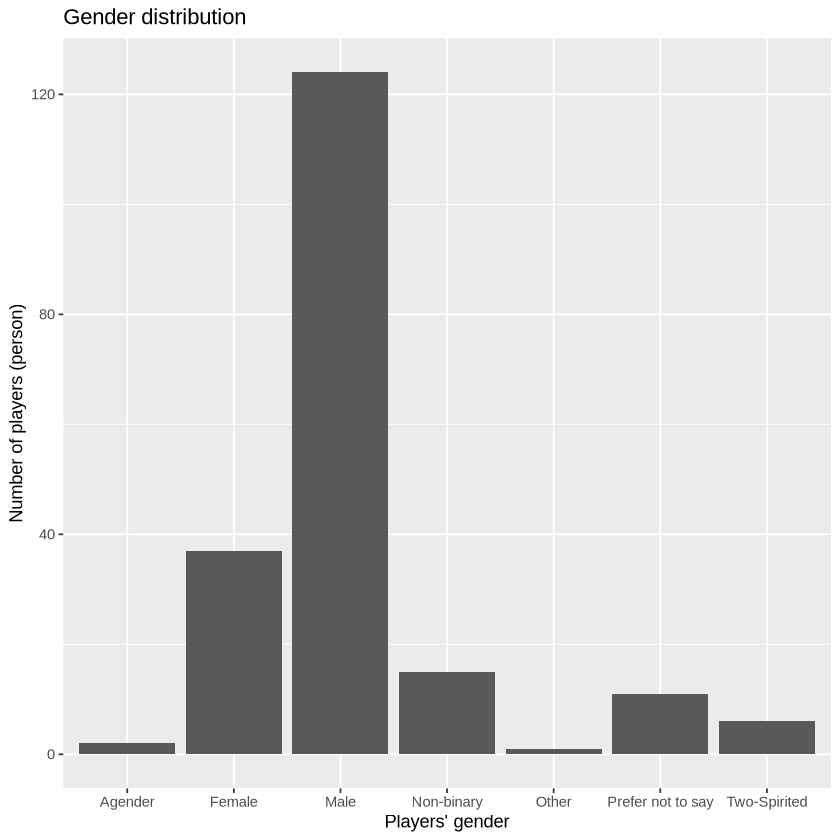

In [27]:
gender_played_hours <- ggplot(players, aes(x = gender)) +
  geom_bar(na.rm = TRUE) +
  labs(x = "Players' gender", y = "Number of players (person)", title = "Gender distribution")

gender_played_hours

In [28]:
players |> count(experience)

experience,n
<chr>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


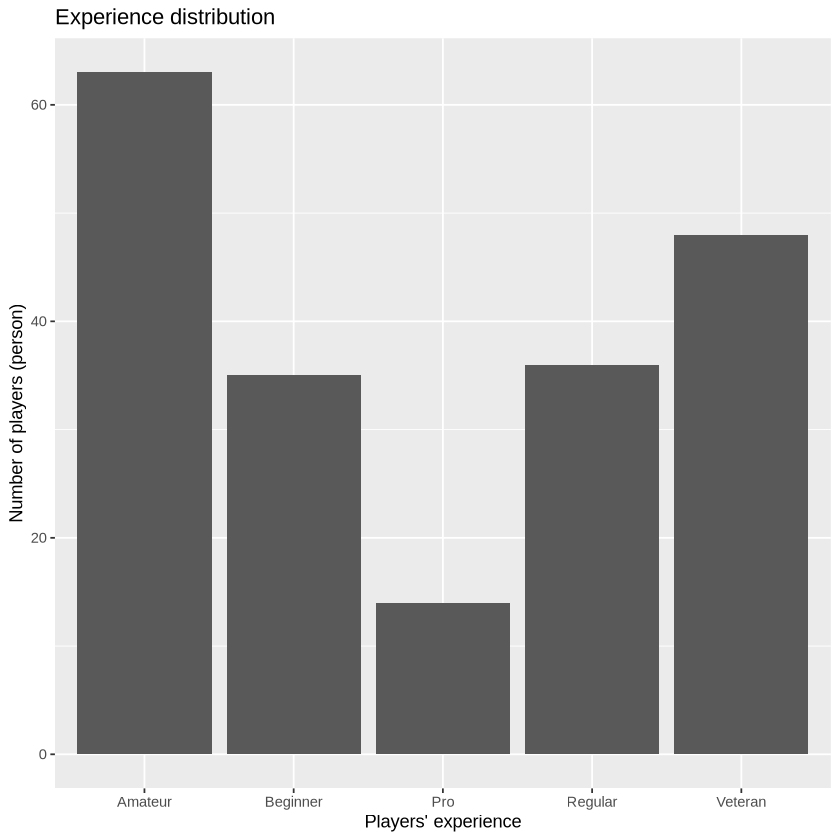

In [6]:
experience_played_hours <- ggplot(players, aes(x = experience)) +
  geom_bar(na.rm = TRUE) +
  labs(x = "Players' experience", y = "Number of players (person)", title = "Experience distribution")
experience_played_hours

In [30]:
players |> count(subscribe)

subscribe,n
<lgl>,<int>
FALSE,52
TRUE,144


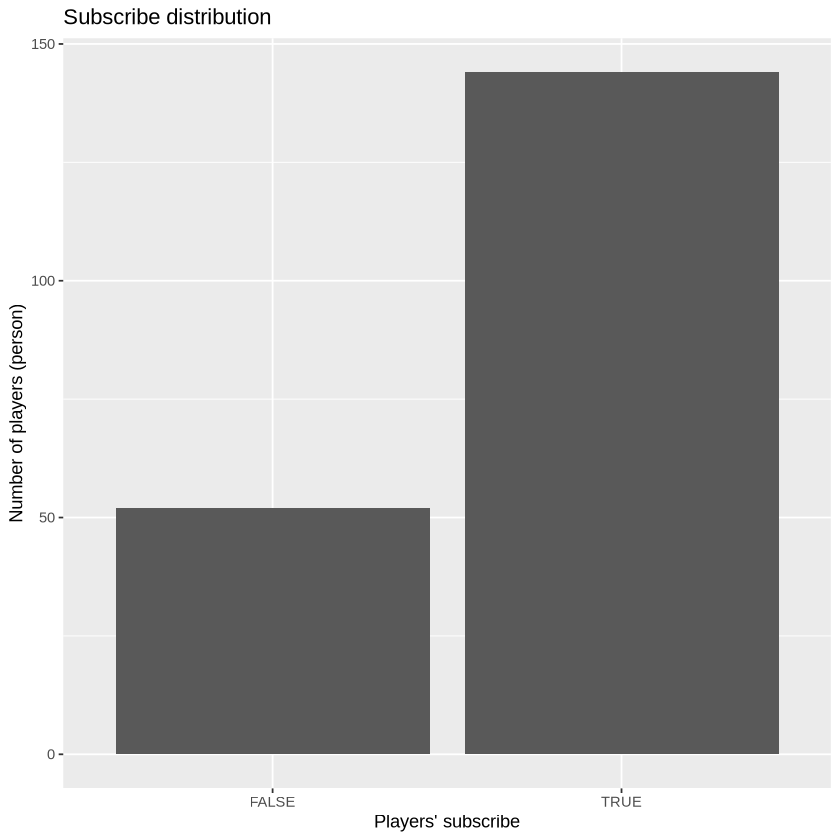

In [31]:
subscribe_played_hours <- ggplot(players, aes(x = subscribe)) +
  geom_bar(na.rm = TRUE) +
  labs(x = "Players' subscribe", y = "Number of players (person)", title = "Subscribe distribution")
subscribe_played_hours

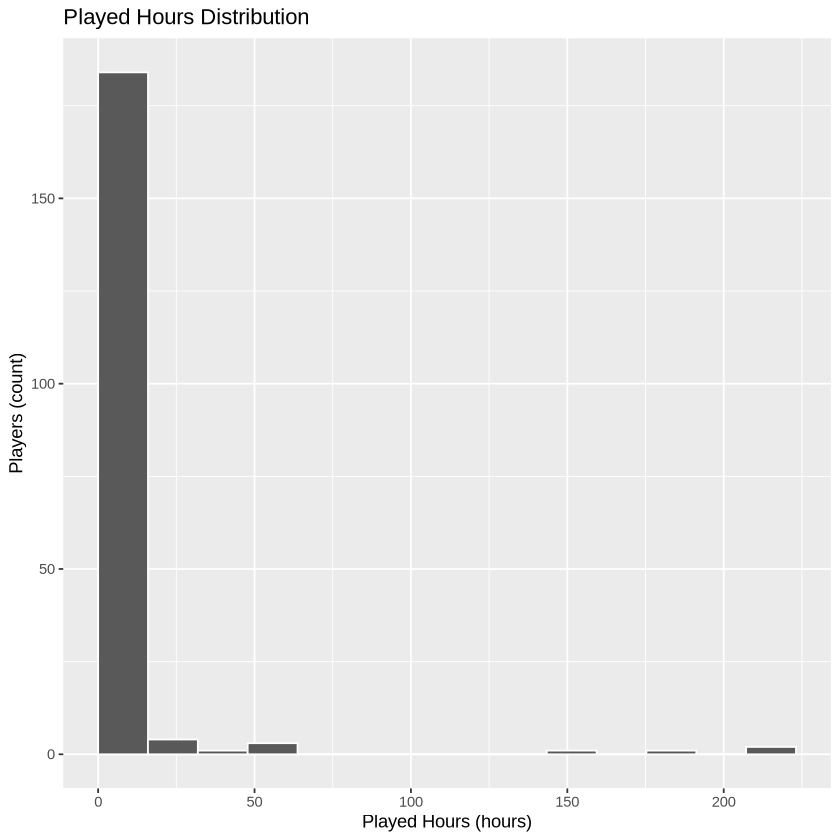

In [14]:
played_hour_distribution <- ggplot(players, aes(x = played_hours)) +
geom_histogram(bins = 15, boundary = 0, color = "white") +
labs(x = "Played Hours (hours)", y = "Players (count)", title = "Played Hours Distribution")
played_hour_distribution

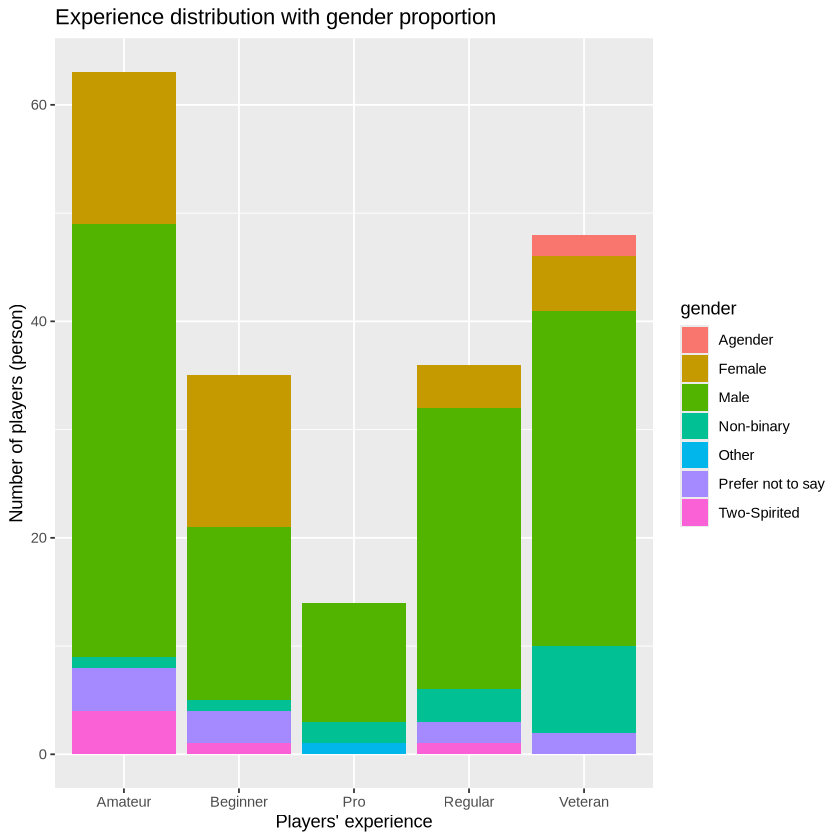

In [12]:
experience_played_hours <- ggplot(players, aes(x = experience, fill = gender)) +
  geom_bar(na.rm = TRUE, position = "stack") +
  labs(x = "Players' experience", y = "Number of players (person)", title = "Experience distribution with gender proportion")
experience_played_hours

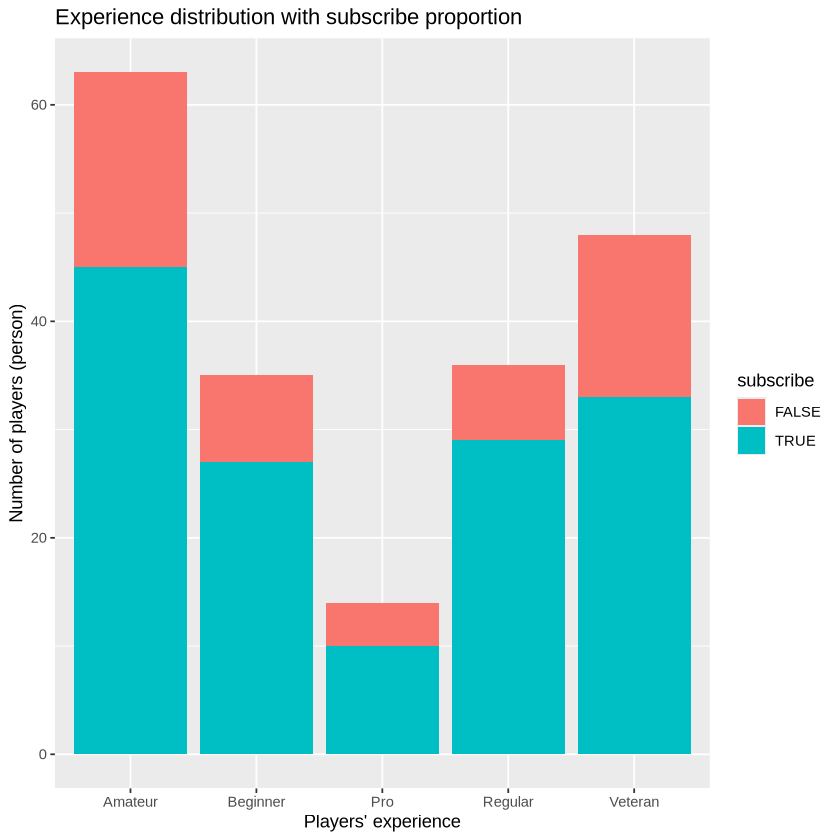

In [15]:
experience_played_hours_subscribe <- ggplot(players, aes(x = experience, fill = subscribe)) +
  geom_bar(na.rm = TRUE, position = "stack") +
  labs(x = "Players' experience", y = "Number of players (person)", title = "Experience distribution with subscribe proportion")
experience_played_hours_subscribe

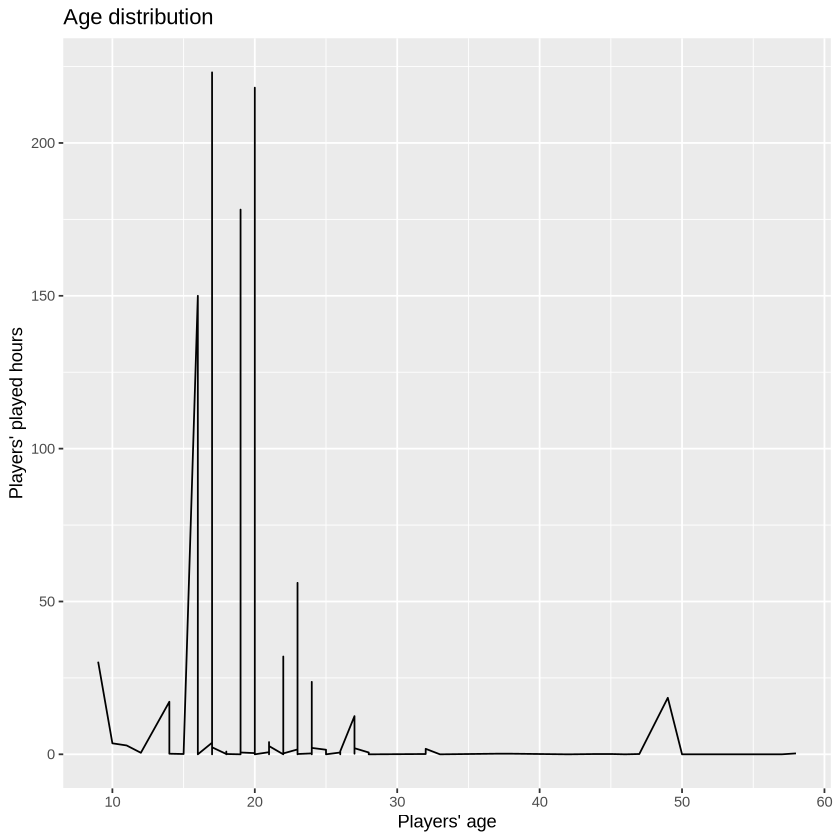

In [32]:
age_played_hours <- ggplot(players, aes(x = Age, y = played_hours)) +
geom_line(na.rm = TRUE) + 
labs(x = "Players' age", y = "Players' played hours", title = "Age distribution") 
age_played_hours

In [33]:
experience_group_played_hours <- players |>
group_by(experience) |>
summarize(average_played_hours = mean(played_hours, na.rm = TRUE))
experience_group_played_hours

experience,average_played_hours
<chr>,<dbl>
Amateur,6.0174603
Beginner,1.2485714
Pro,2.6000000
Regular,18.2083333
Veteran,0.6479167


In [34]:
age_group_played_hours <- players |>
  group_by(Age) |>
  summarize(average_played_hours = mean(played_hours, na.rm = TRUE))
age_group_played_hours

Age,average_played_hours
<dbl>,<dbl>
9,30.3000000
10,3.6000000
11,2.9000000
12,0.5000000
14,8.7000000
15,0.1000000
16,50.0333333
17,4.8863014
18,0.2285714


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


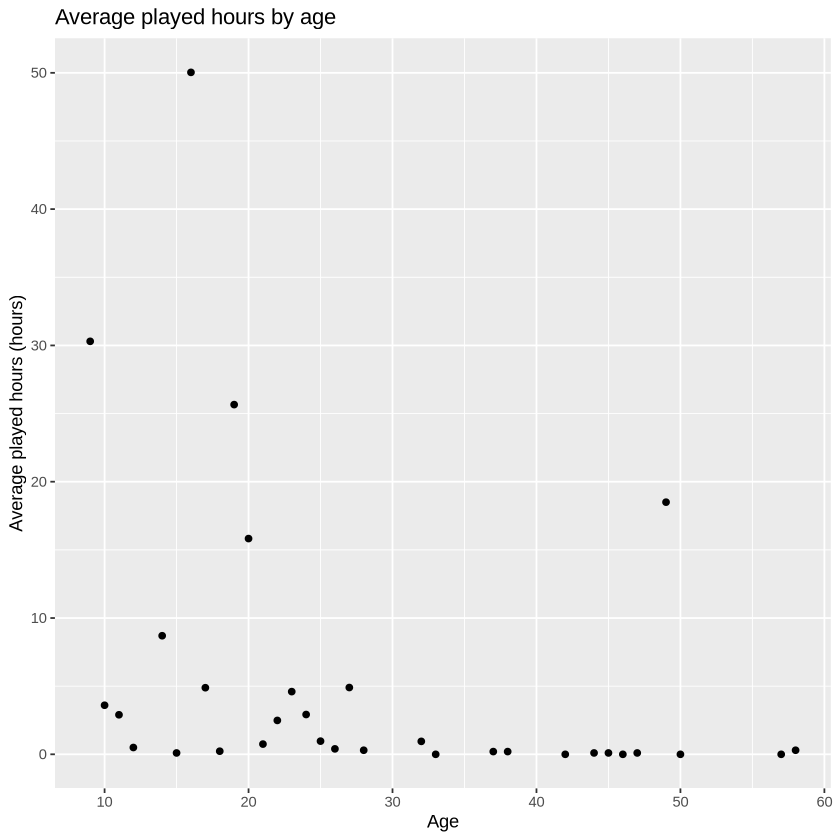

In [35]:

average_age_plot <- age_group_played_hours |>
  ggplot(aes(x = Age, y = average_played_hours)) +
  geom_point() +
  labs(title = "Average played hours by age", x = "Age", y = "Average played hours (hours)") 
average_age_plot

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


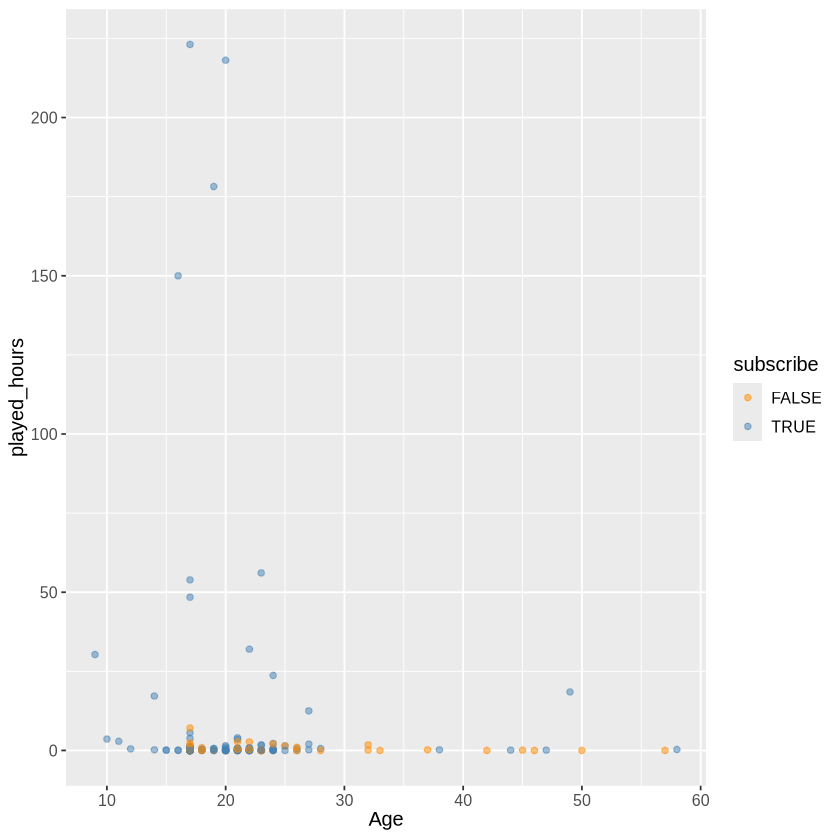

In [26]:
players_a_p <- players |>
ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
geom_point(alpha = 0.5) +
labs(color = "subscribe") +
scale_color_manual(values = c("darkorange", "steelblue")) +
theme(text = element_text(size = 12))
players_a_p

In [24]:
new_obs <- tibble(Age = 44, played_hours = 30)

players_subscribe <- players |>
mutate(subscribe = factor(subscribe, levels = c(FALSE, TRUE))) |>
select(subscribe, Age, played_hours)

players_rec <- recipe(subscribe ~ Age + played_hours, data = players_subscribe) |>
step_normalize(all_numeric_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
set_engine("kknn") |>
set_mode("classification")

players_wf <- workflow() |>
add_recipe(players_rec) |>
add_model(players_spec) |>
fit(data = players_subscribe)

players_predict <- predict(players_wf, new_data = new_obs, type = "class")
players_predict


.pred_class
<fct>
FALSE
